In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import time
import tensorflow as tf
import lightgbm as lgb
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer, Flatten, Conv1D,Conv2D, ConvLSTM3D, Input,MaxPooling1D, concatenate,MaxPooling2D
from tensorflow.keras.regularizers import l1, l2
import keras_tuner
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV,TimeSeriesSplit, KFold
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso

Using TensorFlow backend


# Functions

In [18]:
def read_data_location(location: str):
    """
    Description
    -----------
    Read data from Parquet files located in a specified directory.

    This function reads the training target, observed training data, estimated training data,
    and estimated test data from Parquet files located in the specified directory.
    
    Parameters
    ----------
    - `location` (str): The directory path where the Parquet files are located.

    Returns
    -------
    - A tuple containing the following DataFrames:
      - `train_target` (pandas.DataFrame): Training target data.
      - `X_train_observed` (pandas.DataFrame): Observed training data.
      - `X_train_estimated` (pandas.DataFrame): Estimated training data.
      - `X_test_estimated` (pandas.DataFrame): Estimated test data.

    Example
    -------
    ```python
    data_location = '/path/to/data_directory'
    train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(data_location)
    ```
    """
    train_target = pd.read_parquet('../'+location+'/train_targets.parquet')
    X_train_observed = pd.read_parquet('../'+location+'/X_train_observed.parquet')
    X_train_estimated = pd.read_parquet('../'+location+'/X_train_estimated.parquet')
    X_test_estimated = pd.read_parquet('../'+location+'/X_test_estimated.parquet')
    return(train_target, X_train_observed, X_train_estimated, X_test_estimated)



def find_low_correlation_columns(dataframe, threshold, verbose = True):
    """
    Description
    -----------
    Find and remove columns in a DataFrame with low absolute correlation coefficients.

    This function calculates the pairwise correlation coefficients between columns in a DataFrame and
    removes columns that have absolute correlation coefficients equal to or above the specified threshold.
    It provides the option to print the removed columns for reference.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame for which low correlation columns should be found.
    - `threshold` (float): The threshold for absolute correlation coefficients. Columns with absolute
                      correlation coefficients greater than or equal to this threshold will be removed.
    - `verbose` (bool, optional): If True, print information about removed columns. Default is True.

    Returns
    -------
    - List of column names that remain in the DataFrame after removing low correlation columns.

    Example
    -------
    ```python
    import pandas as pd

    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [2, 3, 4, 5, 6],
            'feature3': [5, 6, 7, 8, 9]}

    df = pd.DataFrame(data)
    threshold = 0.7

    selected_columns = find_low_correlation_columns(df, threshold)
    ```
    """
    
    correlation_matrix = dataframe[:].corr()

    feature_list = list(correlation_matrix.columns)
    removed_list = []
    for reference_index in range(len(feature_list)):
        reference_feature = feature_list[reference_index]

        # Check if this feature has not already been removed
        if reference_feature not in removed_list:
            for compared_index in range(reference_index+1,len(feature_list)):
                compared_feature = feature_list[compared_index]

                # Check if this feature has not already been removed
                if compared_feature not in removed_list:

                    # Get correlation coefficient
                    coefficient = correlation_matrix.loc[reference_feature,compared_feature]

                    # Remove column if it's a NaN
                    if pd.isna(coefficient):
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed {compared_feature} because it is NaN")
                        
                    # Remove if it is above threshold
                    if np.abs(coefficient)>=threshold:
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed \t{compared_feature}\tbecause it is correlated to\t{reference_feature}")
    
    
    output_list = feature_list.copy()
    for element in removed_list:
        output_list.remove(element)
        
    return list(output_list)





def fill_nan(Dataframe: pd.DataFrame, feature: str, verbose: bool = True):
    """
    Description
    -----------
    Fill missing (`NaN`) values in a specified feature of a DataFrame using forward-fill or backward-fill.

    This function checks for missing values in the specified feature and fills them using forward-fill (`ffill`)
    or backward-fill (`bfill`) if necessary. It also provides information about the filled method and missing data.

    Parameters
    ----------
    - `Dataframe` (pandas.DataFrame): The DataFrame containing the feature with missing values.
    - `feature` (str): The name of the feature in the DataFrame.
    - `verbose` (bool): whether to display information about the column being filled and the method used

    Returns
    -------
    - None, but it updates the input DataFrame in place by filling missing values.

    Example
    -------
    ```python
    import pandas as pd

    data = {'date': pd.date_range(start='2023-01-01', periods=100, freq='D'),
            'value': [1, 2, np.nan, 4, np.nan, 6, 7, 8, np.nan, 10]}

    df = pd.DataFrame(data)
    feature = 'value'

    fill_nan(df, feature)
    ```
    """
    it_na = np.where(Dataframe[feature].isna())[0]
    
    #If missing value
    if len(it_na != 0):
        if verbose:
            print("Missing data in",feature," size ",it_na.size," out of", Dataframe.shape[0])
        new_column = Dataframe[feature].ffill()
        method = 'ffill'
        
        if((np.any(new_column.isna()) == True)): 
            method = 'bfill'
            new_column = Dataframe[feature].bfill()
    
        if (np.any(new_column.isna()) == False):
            if verbose:
                print("Filled with",method,"method")
            Dataframe[feature] = new_column
        else:
            if verbose:
                print("WARNING : still NaN values in "+feature)

def load_clean_datasets(location: str, threshold: float,verbose=True):
    """
    Description
    -----------
    Load and preprocess datasets, handling missing values and highly correlated features.

    This function loads four datasets from the specified location and processes them. It replaces colons in column names,
    identifies low-correlation features, and fills missing values using the `fill_nan` function.

    Parameters
    ----------
    - `location` (str): The path or URL to the data files.
    - `threshold` (float): The threshold for feature correlation identification.
    - `verbose` (bool): whether to display information about the dataset being processed

    Returns
    -------
    - Tuple of DataFrames: A tuple containing four DataFrames for train_target, X_train_observed, X_train_estimated, and X_test_estimated.
    - List of Lists of str: A list of lists containing the names of low-correlation features for each DataFrame.

    Example
    -------
    ```python
    train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets("data/location", 0.7)
    ```
    """
    train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(location = location)


    # Process NaNs and highly correlated features
    dataframes = [train_target,X_train_observed,X_train_estimated,X_test_estimated]
    dataframe_names = ["train_target","X_train_observed","X_train_estimated","X_test_estimated"]
    index = 0
    FEATURES = [] # Contains the list of useful features for each dataframe


    for dataframe in dataframes:
        if verbose:
            print("** WORKING ON "+dataframe_names[index]+"**")
        # Replace colons with underscores in column names of 'dataframe'
        dataframe.columns = dataframe.columns.str.replace(':', '_')
        # Find low find_low_correlation_columns
        features = find_low_correlation_columns(dataframe,threshold,verbose=False)
        FEATURES.append(features)
        # Fill NaN
        for feature in dataframe.columns:
            fill_nan(dataframe,feature,verbose=False)
        index+=1
    return (train_target, X_train_observed, X_train_estimated, X_test_estimated,FEATURES)

def select_and_resample(Xdf: pd.DataFrame,Ydf: pd.DataFrame):
    """
    Description
    -----------
    Select and resample time series data.

    This function selects data from two time series dataframes, `Xdf` and `Ydf`, where there is a match in time values.
    It then resamples `Ydf` to a 15-minute interval using linear interpolation and returns the resulting time-aligned data.
    The output data contains only streaks of minutes `[15, 30, 45, 00]`.

    Parameters
    ----------
    - `Xdf` (pandas.DataFrame): The first time series dataframe containing `'date_forecast'` column.
    - `Ydf` (pandas.DataFrame): The second time series dataframe containing `'time'` column.

    Returns
    -------
    - Tuple of two pandas DataFrames:
      - The selected and filtered X values, with a 15-minute interval.
      - The resampled Y values, matching the selected X values.

    Example
    -------
    ```python
    Xdf = pd.DataFrame({'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='15T')})
    Ydf = pd.DataFrame({'time': pd.date_range start='2023-01-01', periods=200, freq='30T')})
    selected_X, selected_Y = select_and_resample(Xdf, Ydf)
    ```
    """
    
    ##### Select Y values where there are X values :
    Y_in_X_times = Ydf['time'].isin(Xdf['date_forecast'])
    Selected_Y = Ydf[Y_in_X_times].reset_index(drop=True)
    
    ##### Select X values where there are Y values
    # ceil the date forecast to the hour in Xdf
    Xdf['hourly_forecast'] = Xdf['date_forecast'].dt.ceil('H')
    X_in_Y_times = Xdf['hourly_forecast'].isin(Selected_Y['time'])
    Selected_X = Xdf[X_in_Y_times].reset_index(drop=True).drop(columns=['hourly_forecast'])

    #### Filter X values to get 4 consecutive 15 minutes
    valid_minutes = [15, 30, 45, 0]
    # Calculate the difference in minutes between consecutive rows
    Selected_X = Selected_X.sort_values('date_forecast')
    Selected_X['minute_diff'] = Selected_X['date_forecast'].diff().dt.total_seconds() / 60
    # Create a mask to identify valid minutes
    valid_mask = Selected_X['minute_diff'].isin(valid_minutes)
    # Create a mask to identify the start of consecutive valid minute streaks
    streak_start_mask = valid_mask & (~valid_mask.shift(1, fill_value=False))
    # Create a mask to identify the end of consecutive valid minute streaks
    streak_end_mask = valid_mask & (~valid_mask.shift(-1, fill_value=False))
    # Merge the start and end masks to get the full streak mask
    consecutive_streak_mask = streak_start_mask | streak_end_mask
    # Extend the streaks to include isolated values
    consecutive_streak_mask = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
    # Repeatedly extend the streaks until no more can be extended
    while True:
        extended_streaks = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
        if extended_streaks.equals(consecutive_streak_mask):
            break
        consecutive_streak_mask = extended_streaks
    # Identify the cases where the streaks start with non-15 minutes
    non_15_start = valid_mask & (streak_start_mask | streak_end_mask)
    consecutive_streak_mask = consecutive_streak_mask | non_15_start

    Selected_X_filtered = Selected_X[consecutive_streak_mask].drop(columns='minute_diff')

    #### Resample Ydf with 15 minute interval 
    Selected_Y.set_index('time', inplace=True)
    Selected_Y_resampled = Selected_Y.resample('15T').interpolate(method='linear') #  use 'nearest' for flatter interpolation
    Selected_Y_resampled = Selected_Y_resampled.reset_index()

    # Select Y resampled values where there are X values :
    Y_in_X_times_resampled = Selected_Y_resampled['time'].isin(Selected_X_filtered['date_forecast'])
    Selected_Y = Selected_Y_resampled[Y_in_X_times_resampled].reset_index(drop=True)
    # Again the other way round to remove data that passed through the filter
    Selected_X = Selected_X_filtered[Selected_X_filtered['date_forecast'].isin(Selected_Y['time'])].reset_index(drop=True)


    return(Selected_X[1:], Selected_Y[1:])  # remove first row which always starts with a 00

def remove_consecutive_identical_values(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values in a specified feature of a DataFrame.

    Paramters
    ---------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = df[feature] != df[feature].shift(+1)

    # Filter and remove rows with consecutive identical values
    filtered_df = df[mask]

    return filtered_df

def remove_consecutive_identical_values_keep_zeros(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values (excluding 0) in a specified feature of a DataFrame.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values (excluding 0) removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 0, 0, 0, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = (df[feature] != df[feature].shift(+1)) | (df[feature] == 0)

    # Filter and remove rows with consecutive identical values, excluding 0
    filtered_df = df[mask]

    return filtered_df


def select_o_clock(dataframe: pd.DataFrame, feature: str) -> pd.DataFrame:
    """
    Description
    -----------
    Select rows from a DataFrame where the time in the specified feature is a round hour (minute and second are 0) and sort them by the 'feature' column.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature column containing time values.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with rows where the time is a round hour, sorted by the 'feature' column.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time_column': pd.date_range(start='2023-01-01', periods=100, freq='H')}

    df = pd.DataFrame(data)
    feature = 'time_column'

    filtered_df = select_o_clock(df, feature)
    ```
    """
     # Check if the feature column exists in the DataFrame
    if feature not in dataframe.columns:
        raise ValueError(f"'{feature}' column not found in the DataFrame")

    # Check if the feature column is of datetime type
    if not pd.api.types.is_datetime64_any_dtype(dataframe[feature]):
        raise ValueError(f"'{feature}' column should be of datetime type")

    # Filter the DataFrame to select rows with round-hour times
    filtered_df = dataframe[dataframe[feature].dt.minute == 0 & (dataframe[feature].dt.second == 0)]
    
    # Sort the filtered DataFrame by the 'feature' column
    filtered_df = filtered_df.sort_values(by=feature)

    return filtered_df

def lagged_features2(df):
    # Define the time intervals for lag
    time_intervals = [15, 30, 45]

    # Create a new DataFrame to store the lagged features
    new_df = df.copy()

    # Loop through the time intervals and create lagged features
    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__r' + str(interval)

        # Loop through the columns in the original DataFrame
        for column in df.columns:
            # Exclude the 'date_forecast' and 'date_calc' columns
            if column not in ['date_forecast', 'date_calc']:
                # Shift the values by the specified time interval
                new_df[column + suffix] = new_df[column].copy().shift(periods=interval//15)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column,verbose=False)

    return new_df

def lagged_features(df, time_intervals = [15,30,45],verbose=False):
    """
    Description
    -----------
    Generate lagged features in a DataFrame based on specified time intervals.

    This function creates lagged features for selected columns in the DataFrame by shifting the data back in time based on
    the provided time intervals. It then fills in missing values using the `fill_nan` function.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to which lagged features will be added.
    - `time_intervals` (List[int]): List of time intervals (in minutes) for creating lagged features.
    - `verbose` (bool): Whether to display information about the lagged features being created.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with lagged features added and missing values filled.

    Example
    -------
    ```python
    data = {'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='H'),
            'value1': [1, 2, 3, 4, 5],
            'value2': [10, 20, 30, 40, 50]}

    df = pd.DataFrame(data)
    time_intervals = [15, 30, 45]

    lagged_df = lagged_features(df, time_intervals)
    ```
    """

    if time_intervals==0:
        return df
    
    new_df = df.copy()      
    new_columns = []

    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__r' + str(interval)

        lagged_df = new_df.shift(interval//15).copy()

        for column in df.columns:
            if column not in ['date_forecast', 'date_calc']:
                lag_name=column + suffix
                if verbose: print(lag_name)
                # Add lagged column
                new_column = pd.DataFrame()
                new_column[lag_name] = new_df[column].copy()
                # Get the value at the shifted time
                mask = (new_df['date_forecast']-pd.to_timedelta(interval, unit='minutes') == lagged_df['date_forecast'])
                new_column.loc[mask,lag_name] = lagged_df.loc[mask,column]
                # Fix values where there is no data available
                new_column.loc[np.logical_not(mask),lag_name]=np.nan
                new_columns.append(new_column)

    new_df = pd.concat([new_df]+new_columns,axis=1)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column,verbose=False)
    
    return new_df


def lagged_features_selected(df,feature_list: list, time_intervals = [15,30,45],verbose=False):

    if feature_list not in df.columns:
        ValueError("Features are not in the DataFrame columns")

    if time_intervals==0:
        return df
    
    new_df = df.copy()      
    new_columns = []

    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__r' + str(interval)

        lagged_df = new_df.shift(interval//15).copy()

        for feature in feature_list:
            if column not in ['date_forecast', 'date_calc', 'sin_day', 'sin_year',' cos_year', 'forecast_interval']:
                lag_name=column + suffix
                if verbose: print(lag_name)
                # Add lagged column
                new_column = pd.DataFrame()
                new_column[lag_name] = new_df[column].copy()
                # Get the value at the shifted time
                mask = (new_df['date_forecast']-pd.to_timedelta(interval, unit='minutes') == lagged_df['date_forecast'])
                new_column.loc[mask,lag_name] = lagged_df.loc[mask,column]
                # Fix values where there is no data available
                new_column.loc[np.logical_not(mask),lag_name]=np.nan
                new_columns.append(new_column)

    new_df = pd.concat([new_df]+new_columns,axis=1)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column,verbose=False)
    
    return new_df


def normalize_dataframe_minmax(df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a DataFrame using min-max scaling, excluding datetime columns.

    This function performs min-max scaling to normalize each column in the DataFrame between 0 and 1,
    excluding datetime columns. It replaces the original values with the scaled values.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns normalized between -1 and 1.

    Example
    -------
    ```python
    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [10, 20, 30, 40, 50],
            'date': pd.date_range(start='2023-01-01', periods=5, freq='D')}

    df = pd.DataFrame(data)

    normalized_df = normalize_dataframe(df)
    ```
    """
    normalized_df = df.copy()
    # Define the range [0, 1]
    min_range = 0
    max_range = 1
    
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            min_val = normalized_df[column].min()
            max_val = normalized_df[column].max()
            if verbose:
                print(f"min:{min_val:.2f}\tmax:{max_val:.2f}")
                print(f"different:{min_val!=max_val}")
            # Normalize the non-datetime column between -1 and 1
            if min_val!=max_val:
                normalized_df[column] = min_range + (max_range - min_range) * (normalized_df[column] - min_val) / (max_val - min_val)
            else :
                normalized_df[column] = min_range + (max_range - min_range) * normalized_df[column]/max(max_val,1)

    return normalized_df

def normalize_dataframe_minmax_TEST(train_df: pd.DataFrame,test_df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a test DataFrame using min-max scaling, based on statistics from a training DataFrame.

    This function performs min-max scaling to normalize each column in the test DataFrame between 0 and 1,
    using the minimum and maximum values from the corresponding columns in the training DataFrame.
    
    Parameters
    ----------
    - `train_df` (pandas.DataFrame): The training DataFrame used to calculate min-max scaling statistics.
    - `test_df` (pandas.DataFrame): The test DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns in the test DataFrame normalized based on the statistics from the training DataFrame.

    Example
    -------
    ```python
    train_data = {'feature1': [1, 2, 3, 4, 5],
                 'feature2': [10, 20, 30, 40, 50]}
    
    test_data = {'feature1': [6, 7, 8, 9, 10],
                'feature2': [60, 70, 80, 90, 100]}
    
    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)
    
    normalized_test_df = normalize_dataframe_TEST(train_df, test_df)
    ```
    """

    normalized_df = test_df.copy()
    # Define the range [0, 1]
    min_range = 0
    max_range = 1
    
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            min_val = train_df[column].min()
            max_val = train_df[column].max()
            if verbose:
                print(f"min:{min_val:.2f}\tmax:{max_val:.2f}")
                print(f"different:{min_val!=max_val}")
            # Normalize the non-datetime column between -1 and 1
            if min_val!=max_val:
                normalized_df[column] = min_range + (max_range - min_range) * (normalized_df[column] - min_val) / (max_val - min_val)
            else :
                normalized_df[column] = min_range + (max_range - min_range) * normalized_df[column]/max(max_val,1)

    return normalized_df

def normalize_dataframe_mean_std(df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a DataFrame using mean and standard deviation scaling.

    This function performs mean and standard deviation scaling to normalize each column in the DataFrame using the
    mean and standard deviation values calculated from the same DataFrame.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns normalized based on mean and standard deviation values.

    Example
    -------
    ```python
    import pandas as pd

    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [10, 20, 30, 40, 50]}

    df = pd.DataFrame(data)

    normalized_df = normalize_dataframe_mean_std(df)
    ```
    """

    normalized_df = df.copy()
    # Iterate over each column and apply mean/std scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            mean = normalized_df[column].mean()
            std = normalized_df[column].std()
            if verbose:
                print(f"mean:{mean:1f} \tstd:{std:.1f}")
            if std!=0:
                normalized_df[column] = (normalized_df[column] - mean) / std
            else :
                normalized_df[column] = (normalized_df[column] - mean) / 1

    return normalized_df



def normalize_dataframe_mean_std_TEST(train_df: pd.DataFrame,test_df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a test DataFrame using mean and standard deviation scaling, based on statistics from a training DataFrame.

    This function performs mean and standard deviation scaling to normalize each column in the test DataFrame using the
    mean and standard deviation values from the corresponding columns in the training DataFrame.

    Parameters
    ----------
    - `train_df` (pandas.DataFrame): The training DataFrame used to calculate mean and standard deviation statistics.
    - `test_df` (pandas.DataFrame): The test DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns in the test DataFrame normalized based on mean and standard deviation
    statistics from the training DataFrame.

    Example
    -------
    ```python
    import pandas as pd

    train_data = {'feature1': [1, 2, 3, 4, 5],
                 'feature2': [10, 20, 30, 40, 50]}
    
    test_data = {'feature1': [6, 7, 8, 9, 10],
                'feature2': [60, 70, 80, 90, 100]}
    
    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)
    
    normalized_test_df = normalize_dataframe_mean_std_TEST(train_df, test_df)
    ```
    """
    normalized_df = test_df.copy()

    # Iterate over each column and apply mean/std scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            mean = train_df[column].mean()
            std = train_df[column].std()
            if verbose:
                print(f"mean:{mean:1f} \tstd:{std:.1f}")
            if std!=0:
                normalized_df[column] = (normalized_df[column] - mean) / std
            else :
                normalized_df[column] = (normalized_df[column] - mean) / 1

    return normalized_df


def convert_datetime(df: pd.DataFrame, time_feature: str):
    new_df = df.copy()

    # Convert the 'time_feature' column to datetime if it's not already
    new_df[time_feature] = pd.to_datetime(new_df[time_feature])

    # Calculate the number of seconds since midnight and subtract it from 86400 to make it -1 at midnight
    new_df['seconds_since_midnight'] = (new_df[time_feature] - new_df[time_feature].dt.normalize()).dt.total_seconds()

    # Calculate the sine of the day with -1 at midnight
    new_df['sin_day'] = np.sin(2 * np.pi * new_df['seconds_since_midnight']/86400- np.pi/2)

    # Calculate the sine of the year with -1 on January 1st
    new_df['sin_year'] = np.sin(2 * np.pi * (new_df[time_feature].dt.dayofyear - 1)/365 - np.pi/2)

    # Calculate the cosine of the year with -1 on January 1st
    new_df['cos_year'] = np.cos(2 * np.pi * (new_df[time_feature].dt.dayofyear - 1)/365 - np.pi/2)

    # Calculate the difference in seconds between 'time_feature' and 'date_calc'
    #new_df['forecast_interval'] = (new_df[time_feature] - new_df['date_calc']).dt.total_seconds().fillna(0)

    # Drop the temporary 'seconds_since_midnight' column if you don't need it
    new_df.drop('seconds_since_midnight', axis=1, inplace=True)

    return new_df

def full_data_loader(location,n_lagged_features=3,threshold=0.9,normalization = 'minmax',date_encoding=True,verbose=True):
    """
    Description
    -----------
    Load, preprocess, and prepare data for training and prediction including feature engineering, normalization, and resampling.

    This function reads datasets, selects usable data, adds date encoding features, lagged features, and normalizes the data.

    Parameters
    ----------
    - `location` (str): The path or URL to the data files.
    - `n_lagged_features` (int): The number of lagged features to add.
    - `threshold` (float): The threshold for feature correlation identification.
    - `normalization` (str): The type of data normalization ('minmax' or 'mean'), or 'none' for no normalization.
    - `date_encoding` (bool): Whether to add date encoding features.
    - `verbose` (bool): Whether to display progress and information.

    Returns
    -------
    - Tuple of DataFrames, Series, and List: A tuple containing X_Train, Y_Train, X_Test, and a list of selected features.

    Example
    -------
    ```python
    location = "data/location"
    n_lagged_features = 3
    threshold = 0.9
    normalization = 'minmax'
    date_encoding = True
    verbose = True

    X_Train, Y_Train, X_Test, selected_features = full_data_loader(
        location, n_lagged_features, threshold, normalization, date_encoding, verbose
    )
    ```
    """
    # Read datasets
    if verbose: print("Reading datasets")
    train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets(location, threshold,verbose=False)
    
    selected_features = FEATURES[-1][1:] # all low correlation features from X_train_observed except date

    # Select usable data and resample training target
    if verbose: print("Selecting training data")
    Ydf = remove_consecutive_identical_values(train_target,'pv_measurement')
    Xdf = pd.concat([X_train_observed,X_train_estimated]).reset_index(drop=True)
    X_Train,Y_Train = select_and_resample(Xdf,Ydf)
    
    # Add features to encode the date information
    if date_encoding:
        if verbose: print("Encoding date information")
        X_Train = convert_datetime(X_Train,'date_forecast')
        X_Test = convert_datetime(X_test_estimated, 'date_forecast')
        # 
    else:
        X_Test = X_test_estimated
    
    if date_encoding:
        selected_features += ['sin_day','sin_year','cos_year']

    # Add lagged features
    if n_lagged_features!=0:
        if verbose: print("Adding lag features")
        time_lags = [15*n for n in range(1,n_lagged_features+1)] # in minutes
        X_Train = lagged_features(X_Train,time_intervals=time_lags,verbose=False)
        X_Test = lagged_features(X_Test,time_intervals=time_lags,verbose=False)
        feature_list = selected_features
        suffix_list = ['']+[f"__r{lag}" for lag in time_lags]
        selected_features = [f+suffix for f in feature_list for suffix in suffix_list]


    # Normalize datasets
    if normalization in ['minmax', 'mean']:
        if verbose:print("Normalizing with "+normalization)
        if normalization == 'minmax':
            X_Train_normal = normalize_dataframe_minmax(X_Train)
            X_Test_normal = normalize_dataframe_minmax_TEST(X_Train,X_Test)
        if normalization == 'mean':
            X_Train_normal = normalize_dataframe_mean_std(X_Train)
            X_Test_normal = normalize_dataframe_mean_std_TEST(X_Train,X_Test)
        X_Train = X_Train_normal
        X_Test = X_Test_normal


    
    print("\nDone\n")
    return (X_Train,Y_Train['pv_measurement'],X_Test,selected_features)


def normalize_dataframe_minmax_ObsEst(df_obs: pd.DataFrame,df_est: pd.DataFrame,df_test: pd.DataFrame,verbose = False):

    normalized_train_obs = df_obs.copy()
    normalized_train_est = df_est.copy()
    normalized_test = df_test.copy()
    # Define the range [0, 1]
    min_range = 0
    max_range = 1
    
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in df_obs.columns:
        if verbose:
            print(column)
        if df_obs[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            min_val = min(df_obs[column].min(),df_est[column].min(),df_test[column].min())
            max_val = max(df_obs[column].max(),df_est[column].max(),df_test[column].max())
            if verbose:
                print(f"min:{min_val:.2f}\tmax:{max_val:.2f}")
                print(f"different:{min_val!=max_val}")
            # Normalize the non-datetime column between -1 and 1
            if min_val!=max_val:
                normalized_train_obs[column] = min_range + (max_range - min_range) * (normalized_train_obs[column] - min_val) / (max_val - min_val)
                normalized_train_est[column] = min_range + (max_range - min_range) * (normalized_train_est[column] - min_val) / (max_val - min_val)
                normalized_test[column] = min_range + (max_range - min_range) * (normalized_test[column] - min_val) / (max_val - min_val)
            else :
                normalized_train_obs[column] = min_range + (max_range - min_range) * normalized_train_obs[column]/max(max_val,1)
                normalized_train_est[column] = min_range + (max_range - min_range) * normalized_train_est[column]/max(max_val,1)
                normalized_test[column] = min_range + (max_range - min_range) * normalized_test[column]/max(max_val,1)

    return (normalized_train_obs, normalized_train_est, normalized_test)


def normalize_dataframe_meanstd_ObsEst(df_obs: pd.DataFrame,df_est: pd.DataFrame,df_test: pd.DataFrame,verbose = False):

    normalized_df_obs = df_obs.copy()
    normalized_df_est = df_est.copy()
    normalized_test = df_test.copy()
        
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in df_obs.columns:
        if verbose:
            print(column)
        if column != 'date_forecast':
            mean = np.mean((df_obs[column].mean(),df_est[column].mean(),df_test[column].mean()))
            std = np.mean((df_obs[column].std(),df_est[column].std(),df_test[column].std()))
            if verbose:
                print(f"mean:{mean:.2f}\tstd:{std:.2f}")
            # Normalize the non-datetime column between -1 and 1
            if std!=0:
                normalized_df_obs[column] = (normalized_df_obs[column] - mean) / std
                normalized_df_est[column] = (normalized_df_est[column] - mean) / std
                normalized_test[column] = (normalized_test[column] - mean) / std
            else :
                normalized_df_obs[column] = (normalized_df_obs[column] - mean) / 1
                normalized_df_est[column] = (normalized_df_est[column] - mean) / 1
                normalized_test[column] = (normalized_test[column] - mean) / 1

    return (normalized_df_obs, normalized_df_est, normalized_test)


def full_data_loader_separate(location,n_lagged_features=3,threshold=0.9,normalization = 'minmax',date_encoding=True,verbose=True):
    """
    Description
    -----------
    Load, preprocess, and prepare data for training and prediction including feature engineering, normalization, and resampling.

    This function reads datasets, selects usable data, adds date encoding features, lagged features, and normalizes the data.

    Parameters
    ----------
    - `location` (str): The path or URL to the data files.
    - `n_lagged_features` (int): The number of lagged features to add.
    - `threshold` (float): The threshold for feature correlation identification.
    - `normalization` (str): The type of data normalization ('minmax' or 'mean'), or 'none' for no normalization.
    - `date_encoding` (bool): Whether to add date encoding features.
    - `verbose` (bool): Whether to display progress and information.

    Returns
    -------
    - Tuple of DataFrames, Series, and List: A tuple containing X_Train_obs,X_Train_est, Y_Train_obs,Y_Train_est X_Test_normalized_obs,X_Test_normalized_est and a list of selected features.

    Example
    -------
    ```python
    location = "data/location"
    n_lagged_features = 3
    threshold = 0.9
    normalization = 'minmax'
    date_encoding = True
    verbose = True

    X_Train, Y_Train, X_Test, selected_features = full_data_loader(
        location, n_lagged_features, threshold, normalization, date_encoding, verbose
    )
    ```
    """
    # Read datasets
    if verbose: print("Reading datasets")
    train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets(location, threshold,verbose=False)
    
    X_train_estimated = X_train_estimated.drop(columns='date_calc')
    X_test_estimated = X_test_estimated.drop(columns='date_calc')
    
    selected_features = FEATURES[-1][1:] # all low correlation features from X_train_observed except date

    # Select usable data and resample training target
    if verbose: print("Selecting training data")
    Ydf = remove_consecutive_identical_values(train_target,'pv_measurement')
    X_Train_obs, Y_Train_obs = select_and_resample(X_train_observed, Ydf)
    X_Train_est, Y_Train_est = select_and_resample(X_train_estimated, Ydf)

 
    # Add features to encode the date information
    if date_encoding:
        if verbose: print("Encoding date information")
        X_Train_obs = convert_datetime(X_Train_obs,'date_forecast')
        X_Train_est = convert_datetime(X_Train_est,'date_forecast')
        X_Test = convert_datetime(X_test_estimated, 'date_forecast')
        # 
    else:
        X_Test = X_test_estimated
    
    if date_encoding:
        selected_features += ['sin_day','sin_year','cos_year']

    # Add lagged features
    if n_lagged_features!=0:
        if verbose: print("Adding lag features")
        time_lags = [15*n for n in range(1,n_lagged_features+1)] # in minutes
        X_Train_obs = lagged_features(X_Train_obs,time_intervals=time_lags,verbose=False)
        X_Train_est = lagged_features(X_Train_est,time_intervals=time_lags,verbose=False)
        X_Test = lagged_features(X_Test,time_intervals=time_lags,verbose=False)
        feature_list = selected_features
        suffix_list = ['']+[f"__r{lag}" for lag in time_lags]
        selected_features = [f+suffix for f in feature_list for suffix in suffix_list]
   

    # Normalize datasets
    if normalization in ['minmax', 'mean']:
        if verbose:print("Normalizing with "+normalization)
        if normalization == 'minmax':
            X_Train_obs_normal,X_Train_est_normal,X_Test_normal = normalize_dataframe_minmax_ObsEst(X_Train_obs,X_Train_est,X_Test)
        if normalization == 'mean':
            X_Train_obs_normal,X_Train_est_normal,X_Test_normal = normalize_dataframe_meanstd_ObsEst(X_Train_obs,X_Train_est,X_Test)
        X_Train_obs = X_Train_obs_normal
        X_Train_est = X_Train_est_normal
        X_Test = X_Test_normal


        
    print("\nDone\n")
    return (X_Train_obs,X_Train_est,Y_Train_obs,Y_Train_est,X_Test,selected_features)


def create_NN_model(input_shape):
    """
    Description
    -----------
    Create a neural network model.

    Parameters
    ----------
    - input_shape (tuple): The shape of the input data

    Returns
    ---------
    - tf.keras.Model: A TensorFlow/Keras neural network model.
    """

    model_NN = Sequential()
    model_NN.add(Input(shape=(input_shape)))
    model_NN.add(Dense(input_shape, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))    # Input layer
    model_NN.add(Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))            # Hidden layer
    model_NN.add(Dense(512, activation='relu'))            # Hidden layer
    model_NN.add(Dropout(0.2))                             # 20% dropout layer
    model_NN.add(Dense(256, activation='relu'))            # Hidden layer
    model_NN.add(Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))            # Hidden layer
    model_NN.add(Dropout(0.2))                             # 20% dropout layer
    model_NN.add(Dense(64, activation='relu'))             # Hidden layer
    model_NN.add(Dropout(0.2))                             # 20% dropout layer
    model_NN.add(Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))             # Hidden layer
    model_NN.add(Dense(1, activation='linear')) # Output layer

    return model_NN

def reshape_data_for_LSTM(X_dataframe, n_lag):
    """
    Description
    -----------
    Reshape Dataframe for input into LSTM model.
    
    Parameters
    ----------
    - X_dataframe (Dataframe) : Dataframe to reshape. Lagged feature as to be next to each other in the column
    - n_lag (int) : Number of lag available in the Dataframe

    Returns:
    - X_to_return (numpy array) : Dataset reshaped.
    """

    n_feature = round(X_dataframe.shape[1]/(n_lag+1))
    
    X_to_return = np.zeros((X_dataframe.shape[0],n_lag+1,n_feature))
    for i in range(0,n_feature):
        X_to_return[:,:,i] = X_dataframe.iloc[:,(n_lag+1)*i:(n_lag+1)*i+n_lag+1]
    return X_to_return

def remove_lagged_features(Dataframe):
    """
    Description
    -----------
    Remove lagged feature in Dataframe.
    
    Parameters
    ----------
    - Dataframe (Dataframe) : Dataframe where lagged feature has to be removed. Lagged features as to contain '_r' in their column's names

    Returns:
    - dataframe_new (Dataframe) : Dataframe without lagged features
    """

    columns = Dataframe.columns
    mask = filter(lambda a: '_r' in a, columns)
    columns_to_deleted = list(mask)
    dataframe_new = Dataframe.drop(columns = columns_to_deleted)
    return dataframe_new

def create_LSTM_CNN_model(n_lagged_features, X_Train_LSTM, X_Train_CNN, value_L2_LSTM=1e-3):
    # Network implementation
    #Parameters
    input_shape_CNN = (n_lagged_features+1, X_Train_LSTM.shape[2])
    input_shape_LSTM = (n_lagged_features+1, X_Train_LSTM.shape[2])

    #CNN part
    inputs1 = Input(shape = input_shape_CNN)
    x1 = Conv1D(filters = 32, kernel_size=n_lagged_features+1,strides=1,padding='same',
                activation='relu',use_bias=True, input_shape=input_shape_CNN)(inputs1)
    x1 = MaxPooling1D(pool_size = 2, strides = None, padding = 'valid')(x1)
    x1 = Conv1D(filters = 16,kernel_size = 2,padding = 'same', activation='relu')(x1)
    x1 = MaxPooling1D(pool_size = 2, strides = None, padding = 'valid')(x1)
    outputs1 = Flatten()(x1) # Flattening to be able to concatenate

    #LSTM part
    inputs2 = Input(shape = input_shape_LSTM)
    x2 = LSTM(units=X_Train_LSTM.shape[2]*n_lagged_features, activation='relu',return_sequences = True, 
                        input_shape=(n_lagged_features+1, X_Train_LSTM.shape[2]),
                        kernel_regularizer=l2(value_L2_LSTM))(inputs2)
    x2 = LSTM(units = 75,activation='relu',return_sequences = True, kernel_regularizer=l2(value_L2_LSTM))(x2)
    x2 = LSTM(units = 50, activation='relu',kernel_regularizer=l2(value_L2_LSTM))(x2)
    outputs2 = Flatten()(x2)

    #Final network
    x = concatenate([outputs1, outputs2])
    x = Dense(32, activation = 'relu', use_bias = True)(x)
    x = Dense(16, activation = 'relu', use_bias = True)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1,activation = 'linear')(x) 

    model_LSTM_CNN = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="CNN_LSTM")
    
    return model_LSTM_CNN

def normalized_removed_lag_from_prediction(X_Train_estimated, prediction_LSTM_CNN, prediction_LGB):
    #Normalized predictions
    scaler_LSTM_CNN = StandardScaler()
    scaler_lgb = StandardScaler()

    prediction_LSTM_CNN_normalize = scaler_LSTM_CNN.fit_transform(prediction_LSTM_CNN)
    prediction_lgb_normalize = scaler_lgb.fit_transform(np.reshape(prediction_LGB, (prediction_LGB.shape[0],1)))

    #Add predictions as features
    X_Train_estimated.insert(X_Train_estimated.shape[1],'prediction_LSTM_CNN',prediction_LSTM_CNN_normalize)
    X_Train_estimated.insert(X_Train_estimated.shape[1],'prediction_LGB',prediction_lgb_normalize)

    #Remove lags features
    X_Train_estimated = remove_lagged_features(X_Train_estimated)
    
    return X_Train_estimated, scaler_LSTM_CNN, scaler_lgb


def normalized_removed_lag_from_prediction_TEST(prediction_LSTM_CNN, prediction_LGB, scaler_LSTM_CNN, scaler_lgb, X_Test):
    #Add normalized prediction as features
    normalized_prediction_LSTM_CNN = scaler_LSTM_CNN.transform(prediction_LSTM_CNN)
    normalized_prediction_lgb = scaler_lgb.transform( np.reshape(prediction_LGB, (prediction_LGB.shape[0],1) ))
    X_Test.insert(X_Test.shape[1],'prediction_LSTM_CNN',normalized_prediction_LSTM_CNN)
    X_Test.insert(X_Test.shape[1],'prediction_LGB',normalized_prediction_lgb)
    #Remove lags features
    X_Test = remove_lagged_features(X_Test)
    return X_Test


In this notebook observed data and estimated data are treated differently.
 
First we use observed data for training an LSTM/CNN network and a LGB regressor. Then we use those trained models to make prediction for estimated data and used this two predictions as feature for a final training with a catboost model.

# Read data and pre-processing

In [5]:
LOCATION = "C"
n_lagged_features = 3
threshold = 0.9
RANDOM_SEED = 42

X_Train_obs, X_Train_est, Y_Train_obs_init, Y_Train_est_init,X_Test, selected_features = full_data_loader_separate(location = LOCATION,
                                                        n_lagged_features=n_lagged_features,
                                                        threshold=threshold,
                                                        normalization = 'mean',
                                                        date_encoding=True,
                                                        verbose=True)

# With interpolation
X_Train_obs_init, X_Train_est_init,X_Test_init = X_Train_obs[selected_features], X_Train_est[selected_features], X_Test[selected_features]
Y_Train_obs_init = Y_Train_obs_init['pv_measurement']
Y_Train_est_init = Y_Train_est_init['pv_measurement']

# Normalized same data with min/max normalization
X_Train_obs_init_minmax, X_Train_est_init_minmax,X_Test_init_minmax = normalize_dataframe_minmax_ObsEst(X_Train_obs_init, X_Train_est_init,X_Test_init)

print("\nNbr samples of observed data = ", X_Train_obs_init.shape[0],'\n',
      "Nbr samples of estimated data = ", X_Train_est_init.shape[0],'\n',
      "Nbr of features = ",X_Train_obs_init.shape[1]
      )

Reading datasets
Selecting training data
Encoding date information
Adding lag features
Normalizing with mean

Done


Nbr samples of observed data =  37480 
 Nbr samples of estimated data =  4876 
 Nbr of features =  116


## First layer composed of LSTM/CNN network and LGB
Work only on observed data

LSTM/CNN

In [6]:
#Split observed data into Train Test, Validation sets, both normalization with same shuffle
X_obs = pd.concat((X_Train_obs_init, X_Train_obs_init_minmax), axis = 1)

X_Train_, X_Test, Y_Train_, Y_Test = train_test_split(X_obs,Y_Train_obs_init,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Train_, Y_Train_,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )

#Unfold to separate both normalization : X_Train = Mean_norm ; X_Train_CNN = Min/Max norm
X_Train, X_Train_CNN = pd.DataFrame(X_Train.iloc[:,0:X_Train_obs_init.shape[1]]), pd.DataFrame(X_Train.iloc[:,X_Train_obs_init.shape[1]:] )
X_Val, X_Val_CNN = pd.DataFrame(X_Val.iloc[:,0:X_Train_obs_init.shape[1]]), pd.DataFrame(X_Val.iloc[:,X_Train_obs_init.shape[1]:] )
X_Test, X_Test_CNN = pd.DataFrame( X_Test.iloc[:,0:X_Train_obs_init.shape[1]]), pd.DataFrame(X_Test.iloc[:,X_Train_obs_init.shape[1]:] )

In [7]:
#Min-max normalization for CNN layers, Mean-std normalization for LSTM layers

#Reshape data for CNN layers
X_Train_CNN = reshape_data_for_LSTM(X_Train_CNN,n_lagged_features)
X_Val_CNN   = reshape_data_for_LSTM(X_Val_CNN,n_lagged_features)
X_Test_CNN  = reshape_data_for_LSTM(X_Test_CNN,n_lagged_features)

#Reshape data for LSTM layers
X_Train_LSTM = reshape_data_for_LSTM(X_Train,n_lagged_features)
X_Val_LSTM   = reshape_data_for_LSTM(X_Val,n_lagged_features)
X_Test_LSTM  = reshape_data_for_LSTM(X_Test,n_lagged_features)


#Create and trained the network
model_LSTM_CNN  = create_LSTM_CNN_model(n_lagged_features, X_Train_CNN, X_Train_LSTM)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 20, 
                                                  mode = "min", 
                                                  verbose=1,
                                                  restore_best_weights = False, 
                                                  start_from_epoch = 20)

model_LSTM_CNN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mae')
history = model_LSTM_CNN.fit(x=[X_Train_CNN,X_Train_LSTM],
                    y=Y_Train,
                    batch_size = 256, 
                    steps_per_epoch=1, 
                    epochs=500, 
                    verbose=2,
                    validation_data = ([X_Val_CNN,X_Val_LSTM], Y_Val),
                    callbacks = [early_stopping] 
                    )

Epoch 1/500
1/1 - 4s - loss: 188.7425 - val_loss: 200.1346 - 4s/epoch - 4s/step
Epoch 2/500
1/1 - 0s - loss: 203.0289 - val_loss: 200.0848 - 242ms/epoch - 242ms/step
Epoch 3/500
1/1 - 0s - loss: 181.5957 - val_loss: 200.0377 - 239ms/epoch - 239ms/step
Epoch 4/500
1/1 - 0s - loss: 216.8373 - val_loss: 199.9887 - 227ms/epoch - 227ms/step
Epoch 5/500
1/1 - 0s - loss: 193.7518 - val_loss: 199.9357 - 225ms/epoch - 225ms/step
Epoch 6/500
1/1 - 0s - loss: 179.0762 - val_loss: 199.8764 - 259ms/epoch - 259ms/step
Epoch 7/500
1/1 - 0s - loss: 183.4432 - val_loss: 199.8097 - 240ms/epoch - 240ms/step
Epoch 8/500
1/1 - 0s - loss: 184.4018 - val_loss: 199.7351 - 230ms/epoch - 230ms/step
Epoch 9/500
1/1 - 0s - loss: 188.4165 - val_loss: 199.6523 - 228ms/epoch - 228ms/step
Epoch 10/500
1/1 - 0s - loss: 192.8665 - val_loss: 199.5621 - 227ms/epoch - 227ms/step
Epoch 11/500
1/1 - 0s - loss: 220.0591 - val_loss: 199.4642 - 236ms/epoch - 236ms/step
Epoch 12/500
1/1 - 0s - loss: 172.7572 - val_loss: 199.357

LGB Regressor

In [8]:
lgb_model = lgb.LGBMRegressor(tree_learner= 'serial',
                              num_threads= 2,
                              num_leaves= 500,
                              n_estimators= 1000,
                              metric= 'mae',
                              reg_lambda = 0.001,
                              reg_alpha= 0.001,
                              learning_rate= 0.08)
lgb_model.fit(X_Train,Y_Train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15923
[LightGBM] [Info] Number of data points in the train set: 23987, number of used features: 114
[LightGBM] [Info] Start training from score 196.759746


LGBMRegressor(learning_rate=0.08, metric='mae', n_estimators=1000,
              num_leaves=500, num_threads=2, reg_alpha=0.001, reg_lambda=0.001,
              tree_learner='serial')

Make prediction on estimated data with both models

153/153 [==============================] - 1s 4ms/step
mae with LSTM/CNN network=  50.03132303203222
mae with lgb=  59.74185212331431


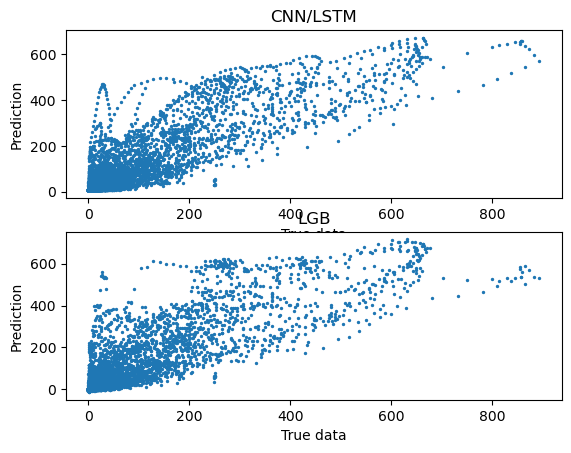

In [9]:
#Predict on estimated data with LSTM/CNN Netwotk
X_Train_CNN_est_init = reshape_data_for_LSTM(X_Train_est_init_minmax, n_lagged_features)
X_Train_LSTM_est_init = reshape_data_for_LSTM(X_Train_est_init,n_lagged_features)
prediction_LSTM_CNN_est =model_LSTM_CNN.predict([X_Train_CNN_est_init,X_Train_LSTM_est_init])

#Predict on estimated data with LGB
prediction_lgb_est = lgb_model.predict(X_Train_est_init)

#Evaluate
mae_lstm_cnn = mean_absolute_error(Y_Train_est_init, prediction_LSTM_CNN_est)
mae_lgb = mean_absolute_error(Y_Train_est_init, prediction_lgb_est)
print("mae with LSTM/CNN network= ",mae_lstm_cnn)
print("mae with lgb= ",mae_lgb)

plt.subplot(211)
plt.title("CNN/LSTM")
plt.scatter(Y_Train_est_init, prediction_LSTM_CNN_est, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")

plt.subplot(212)
plt.title("LGB")
plt.scatter(Y_Train_est_init, prediction_lgb_est, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

Normalized predictions and remove lag feature for the last training

In [10]:
#Normalized prediction and remove lag features
X_Train_est_init,scaler_LSTM_CNN,scaler_lgb = normalized_removed_lag_from_prediction(X_Train_est_init, prediction_LSTM_CNN_est, prediction_lgb_est)

#Split Train, Validation, Test estimated data
X_Train_est,X_Test_est, Y_Train_est, Y_Test_est = train_test_split(X_Train_est_init, Y_Train_est_init,
                                                    test_size=0.1,
                                                    shuffle=True
                                                    )

Final model hyper-parameters search

In [13]:
RANDOM_SEED = 42

catboost_model = CatBoostRegressor(thread_count=-1,verbose=100,allow_writing_files = False)

grid = {'learning_rate': [ 0.15, 0.20, 0.25, 0.30, 0.35, 0.4],
        'depth': [3,4,5,6,7,8],
        'l2_leaf_reg': [12,13,14,15,16,17,18,19,20]}

randomized_search_result = catboost_model.randomized_search(grid,
                                                   X=X_Train_est,
                                                   y=Y_Train_est,
                                                   plot=True,
                                                   verbose=True,
                                                   n_iter=60,
                                                   partition_random_seed=RANDOM_SEED,
                                                   )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 152.4055943	test: 139.3419631	best: 139.3419631 (0)	total: 10.7ms	remaining: 10.7s
100:	learn: 28.1238710	test: 30.9326314	best: 30.9326314 (100)	total: 161ms	remaining: 1.43s
200:	learn: 22.8573424	test: 26.3583952	best: 26.3583952 (200)	total: 280ms	remaining: 1.11s
300:	learn: 19.8313810	test: 24.1874774	best: 24.1874774 (300)	total: 401ms	remaining: 931ms
400:	learn: 17.4442047	test: 22.3473153	best: 22.3473153 (400)	total: 523ms	remaining: 782ms
500:	learn: 15.6071655	test: 20.8894053	best: 20.8894053 (500)	total: 682ms	remaining: 679ms
600:	learn: 14.2269745	test: 19.7625427	best: 19.7625427 (600)	total: 815ms	remaining: 541ms
700:	learn: 13.0006585	test: 18.9169593	best: 18.9169593 (700)	total: 959ms	remaining: 409ms
800:	learn: 11.9758870	test: 18.0787538	best: 18.0787538 (800)	total: 1.09s	remaining: 271ms
900:	learn: 11.2032447	test: 17.4219588	best: 17.4219588 (900)	total: 1.21s	remaining: 133ms
999:	learn: 10.5273423	test: 16.8765678	best: 16.8765678 (999)	total: 

mae =  7.297800290129575


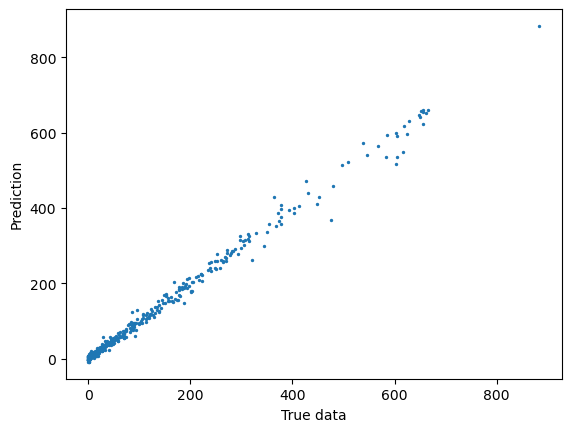

In [15]:
#See result on test data, not useful just to see
prediction_catboost = catboost_model.predict(X_Test_est)
mae = mean_absolute_error(Y_Test_est, prediction_catboost)
print("mae = ",mae)

plt.scatter(Y_Test_est, prediction_catboost, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

Predict on test data for Kaggle

In [16]:
#Network prediction
X_test = reshape_data_for_LSTM(X_Test_init, n_lagged_features)
X_test_CNN = reshape_data_for_LSTM(X_Test_init_minmax, n_lagged_features)
prediction_LSTM_CNN_test =model_LSTM_CNN.predict([X_test_CNN,X_test])

#LGB prediction
prediction_lgb_test = lgb_model.predict(X_Test_init)

#Add normalized prediction as features
normalized_prediction_LSTM_CNN = scaler_LSTM_CNN.transform(prediction_LSTM_CNN_test)
normalized_prediction_lgb = scaler_lgb.transform( np.reshape(prediction_lgb_test, (prediction_lgb_test.shape[0],1) ))
X_Test_init.insert(X_Test_init.shape[1],'prediction_LSTM_CNN',normalized_prediction_LSTM_CNN)
X_Test_init.insert(X_Test_init.shape[1],'prediction_LGB',normalized_prediction_lgb)

#Remove lags features
X_Test = remove_lagged_features(X_Test_init)

print(X_Test.shape)
X_Test.head()

90/90 [==============================] - 0s 4ms/step
(2880, 27)


,air_density_2m_kgm3,ceiling_height_agl_m,clear_sky_energy_1h_J,cloud_base_agl_m,effective_cloud_cover_p,fresh_snow_12h_cm,fresh_snow_1h_cm,is_day_idx,is_in_shadow_idx,msl_pressure_hPa,...,visibility_m,wind_speed_10m_ms,wind_speed_u_10m_ms,wind_speed_v_10m_ms,wind_speed_w_1000hPa_ms,sin_day,sin_year,cos_year,prediction_LSTM_CNN,prediction_LGB
0,1.416994,-0.759055,-1.105872,-0.408165,0.301606,-0.152495,-0.099414,-2.678885,1.758356,-0.021892,...,-0.178776,0.418513,0.285630,1.540447,0.000113,-2.476352,0.43066,1.020867,-0.711918,-0.677853
1,1.416994,-0.759055,-1.105872,-0.391789,0.224077,-0.152495,-0.099414,-2.678885,1.758356,-0.039142,...,-0.185428,0.357882,0.285630,1.540447,0.000113,-2.472442,0.43066,1.020867,-0.712724,-0.673660
2,1.416994,-0.759055,-1.105872,-0.375414,0.146547,-0.152495,-0.099414,-2.678885,1.758356,-0.047764,...,-0.192195,0.357882,0.244914,1.540447,0.000113,-2.460728,0.43066,1.020867,-0.713985,-0.674639
3,1.416994,-0.759055,-1.105872,-0.359038,0.063670,-0.152495,-0.099414,-2.678885,1.758356,-0.056391,...,-0.197744,0.357882,0.244914,1.540447,0.000113,-2.441260,0.43066,1.020867,-0.715569,-0.672202
4,1.416994,-0.759055,-1.105872,-0.342621,-0.021880,-0.152495,-0.099414,-2.678885,1.758356,-0.073635,...,-0.199539,0.357882,0.244914,1.540447,0.000113,-2.414123,0.43066,1.020867,-0.717202,-0.670595


In [27]:
LOCATIONS = ["A","B","C"]
n_lagged_features = 3
threshold = 0.9
RANDOM_SEED = 42

PREDICTIONS = []

for i in LOCATIONS:
    
    print("--- Working on location ---",i)

    ### Load data with feature engineering ###
    X_Train_obs, X_Train_est, Y_Train_obs_init, Y_Train_est_init,X_Test, selected_features = full_data_loader_separate(location = i,
                                                        n_lagged_features=n_lagged_features,
                                                        threshold=threshold,
                                                        normalization = 'mean',
                                                        date_encoding=True,
                                                        verbose=True)

    # With interpolation
    X_Train_obs_init, X_Train_est_init,X_Test_init = X_Train_obs[selected_features], X_Train_est[selected_features], X_Test[selected_features]
    Y_Train_obs_init = Y_Train_obs_init['pv_measurement']
    Y_Train_est_init = Y_Train_est_init['pv_measurement']

    # Normalized same data with min/max normalization
    X_Train_obs_init_minmax, X_Train_est_init_minmax,X_Test_init_minmax = normalize_dataframe_minmax_ObsEst(X_Train_obs_init, X_Train_est_init,X_Test_init)


    ### Work only with observed data ###

    #Split observed data into Train Test, Validation sets, both normalization with same shuffle
    X_obs = pd.concat((X_Train_obs_init, X_Train_obs_init_minmax), axis = 1)
    X_Train_, X_Test, Y_Train_, Y_Test = train_test_split(X_obs,Y_Train_obs_init,
                                                        test_size=0.2,
                                                        shuffle=True
                                                        )
    X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Train_, Y_Train_,
                                                        test_size=0.2,
                                                        shuffle=True
                                                        )

    #Unfold to separate both normalization : X_Train = Mean_norm ; X_Train_CNN = Min/Max norm
    X_Train, X_Train_CNN = pd.DataFrame(X_Train.iloc[:,0:X_Train_obs_init.shape[1]]), pd.DataFrame(X_Train.iloc[:,X_Train_obs_init.shape[1]:] )
    X_Val, X_Val_CNN = pd.DataFrame(X_Val.iloc[:,0:X_Train_obs_init.shape[1]]), pd.DataFrame(X_Val.iloc[:,X_Train_obs_init.shape[1]:] )
    X_Test, X_Test_CNN = pd.DataFrame( X_Test.iloc[:,0:X_Train_obs_init.shape[1]]), pd.DataFrame(X_Test.iloc[:,X_Train_obs_init.shape[1]:] )

    #Min-max normalization for CNN layers, Mean-std normalization for LSTM layers

    #Reshape data for CNN layers
    X_Train_CNN = reshape_data_for_LSTM(X_Train_CNN,n_lagged_features)
    X_Val_CNN   = reshape_data_for_LSTM(X_Val_CNN,n_lagged_features)
    X_Test_CNN  = reshape_data_for_LSTM(X_Test_CNN,n_lagged_features)

    #Reshape data for LSTM layers
    X_Train_LSTM = reshape_data_for_LSTM(X_Train,n_lagged_features)
    X_Val_LSTM   = reshape_data_for_LSTM(X_Val,n_lagged_features)
    X_Test_LSTM  = reshape_data_for_LSTM(X_Test,n_lagged_features)

    #Create and train the LSTM/CNNnetwork
    model_LSTM_CNN  = create_LSTM_CNN_model(n_lagged_features, X_Train_CNN, X_Train_LSTM)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                      patience = 20, 
                                                      mode = "min", 
                                                      verbose=1,
                                                      restore_best_weights = False, 
                                                      start_from_epoch = 20)

    model_LSTM_CNN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mae')
    print("--- Training LSTM/CNN Network ---")
    history = model_LSTM_CNN.fit(x=[X_Train_CNN,X_Train_LSTM],
                        y=Y_Train,
                        batch_size = 256, 
                        steps_per_epoch=1, 
                        epochs=500, 
                        verbose=0,
                        validation_data = ([X_Val_CNN,X_Val_LSTM], Y_Val),
                        callbacks = [early_stopping] 
                        )
    
    #Create and train LGBM Regressor
    print("--- Training LGBM Regressor ---")
    lgb_model = lgb.LGBMRegressor(tree_learner= 'serial',
                              num_threads= 2,
                              num_leaves= 500, 
                              n_estimators= 1000,
                              metric= 'mae',
                              reg_lambda = 0.001,
                              reg_alpha= 0.001,
                              learning_rate= 0.08)
    lgb_model.fit(X_Train,Y_Train)


    ### Working only with estimated data ###
    
    #Predict on estimated data with LSTM/CNN Netwotk
    X_Train_CNN_est_init = reshape_data_for_LSTM(X_Train_est_init_minmax, n_lagged_features)
    X_Train_LSTM_est_init = reshape_data_for_LSTM(X_Train_est_init,n_lagged_features)
    prediction_LSTM_CNN_est =model_LSTM_CNN.predict([X_Train_CNN_est_init,X_Train_LSTM_est_init])

    #Predict on estimated data with LGB
    prediction_lgb_est = lgb_model.predict(X_Train_est_init)

    #Normalized prediction,remove lag features and add predictions as features
    X_Train_est_init,scaler_LSTM_CNN,scaler_lgb = normalized_removed_lag_from_prediction(X_Train_est_init, prediction_LSTM_CNN_est, prediction_lgb_est)
    
    #Create and train Catboost regressor  
    catboost_model = CatBoostRegressor(thread_count=-1,verbose=100,allow_writing_files = False)
    grid = {'learning_rate': [ 0.15, 0.20, 0.25, 0.30, 0.35, 0.4],
            'depth': [3,4,5,6,7,8],
            'l2_leaf_reg': [12,13,14,15,16,17,18,19,20]}

    print("--- Training Catboost ---")    
    randomized_search_result = catboost_model.randomized_search(grid,
                                                       X=X_Train_est_init,
                                                       y=Y_Train_est_init,
                                                       plot=False,
                                                       verbose=False,
                                                       n_iter=60, 
                                                       partition_random_seed=RANDOM_SEED,
                                                       )
    

    ### Applied pipeline stacked model on test data for Kaggle prediction ###
    
    #Network prediction
    X_test = reshape_data_for_LSTM(X_Test_init, n_lagged_features)
    X_test_CNN = reshape_data_for_LSTM(X_Test_init_minmax, n_lagged_features)
    prediction_LSTM_CNN_test =model_LSTM_CNN.predict([X_test_CNN,X_test])
    
    #LGB prediction
    prediction_lgb_test = lgb_model.predict(X_Test_init)
    
    #Add normalized prediction as features
    X_Test = normalized_removed_lag_from_prediction_TEST(prediction_LSTM_CNN_test, prediction_lgb_test, scaler_LSTM_CNN, scaler_lgb, X_Test_init)
    
    #Final prediction
    prediction = catboost_model.predict(X_Test)

    #Concatenation of predictions 
    PREDICTIONS.append(prediction)

--- Working on location --- A
Reading datasets
Selecting training data
Encoding date information
Adding lag features
Normalizing with mean

Done

--- Beginning training LSTM/CNN Network ---
Epoch 330: early stopping
--- Beginning training LGBM Regressor ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15806
[LightGBM] [Info] Number of data points in the train set: 45014, number of used features: 104
[LightGBM] [Info] Start training from score 1141.268474
234/234 [==============================] - 2s 5ms/step
--- Beginning training Catboost ---
0:	learn: 1225.6950253	test: 1211.8030820	best: 1211.8030820 (0)	total: 1.5ms	remaining: 1.5s
100:	learn: 297.7591574	test: 322.9926881	best: 322.9926881 (100)	total: 221ms	remaining: 1.97s
200:	learn: 246.3961488	test: 280.6981376	best: 28

In [23]:
submission = pd.DataFrame(np.concatenate((PREDICTIONS[0],PREDICTIONS[1],PREDICTIONS[2]),axis = 0) ).reset_index()
submission['id'] = submission.index